# News Category Dataset

Bu proje, haber metinlerini otomatik olarak sınıflandırmak için makine öğrenimi tekniklerini kullanmaktadır. Farklı haber kategorilerinin (örneğin, iş, eğlence, sağlık) belirlenmesi amacıyla metin verisi işlenmekte ve derin öğrenme modellemesi yapılmaktadır.

## 🔗 Kaggle Veri Seti
[Haber Kategorisi Veri Seti](https://www.kaggle.com/datasets/rmisra/news-category-dataset)

## 🔗 Hugging Face Uygulaması
[Haber Kategorisi Veri Seti - Hugging Face Space] sorun yaşadım

## 🔗 Uygulama Linki
Uygulamayı yerel olarak çalıştırmak için: [http://localhost:8501/](http://localhost:8501/)

[News Category Dataset - Github](https://github.com/FBetulS/News--Category-Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
# NLTK bileşenlerini indirme
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BETÜL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BETÜL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BETÜL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Veriyi yükleme
with open('News_Category_Dataset_v3.json', 'r') as file:
    data = [json.loads(line) for line in file]

# DataFrame'e dönüştürme
df = pd.DataFrame(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


In [5]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [6]:
df['category'].value_counts()

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

In [17]:
# Metin verilerini birleştirme (başlık ve kısa açıklama)
df['text'] = df['headline'] + ' ' + df['short_description']

In [19]:
# Metin temizleme fonksiyonu
def clean_text(text):
    # Küçük harfe dönüştürme
    text = text.lower()
    # Noktalama işaretlerini kaldırma
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Fazladan boşlukları kaldırma
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize etme
    tokens = word_tokenize(text)
    # Stopword'leri kaldırma
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [21]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [22]:
# Örnek metinleri görelim
print("\nTemizlenmiş metin örnekleri:")
for i in range(3):
    print(f"Orijinal: {df['text'].iloc[i][:100]}...")
    print(f"Temizlenmiş: {df['cleaned_text'].iloc[i][:100]}...")
    print()


Temizlenmiş metin örnekleri:
Orijinal: Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it ...
Temizlenmiş: 4 million american roll sleeve omicron targeted covid booster health expert said early predict wheth...

Orijinal: American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was sub...
Temizlenmiş: american airline flyer charged banned life punching flight attendant video subdued passenger crew fl...

Orijinal: 23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don'...
Temizlenmiş: 23 funniest tweet cat dog week sept 17 23 dog understand could eaten...




Kategori dağılımı:


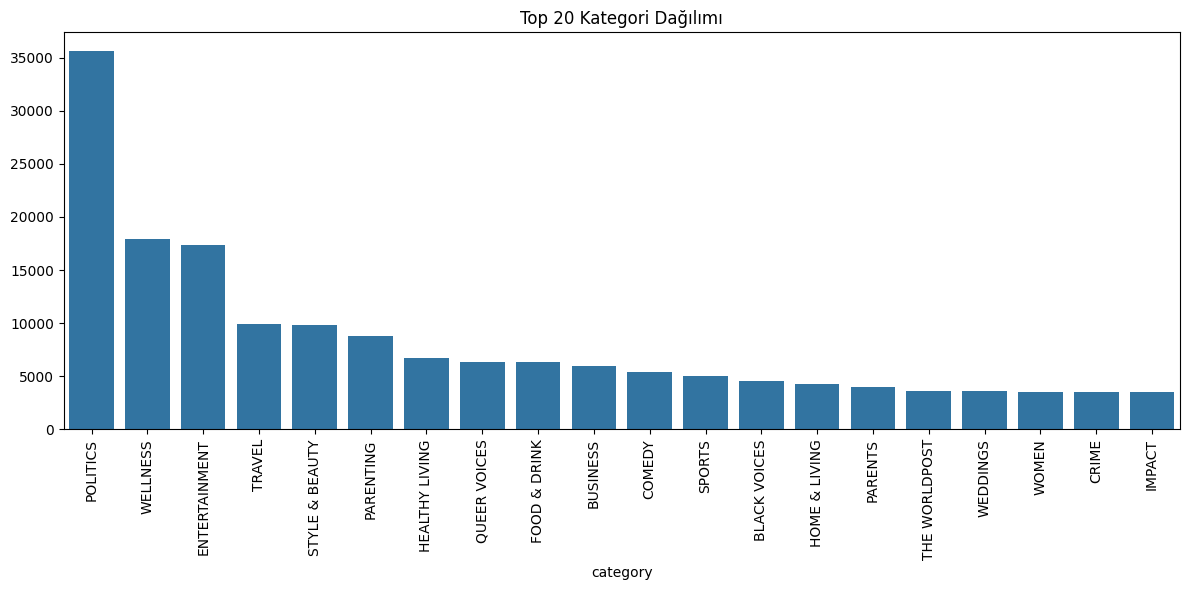

In [23]:
# Kategorileri inceleme
print("\nKategori dağılımı:")
plt.figure(figsize=(12, 6))
top_categories = df['category'].value_counts().head(20)
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.xticks(rotation=90)
plt.title('Top 20 Kategori Dağılımı')
plt.tight_layout()
plt.show()

Veri setini düzenleme - sadece en popüler kategorileri alalım

Eğitim süresini azaltmak için top 10 kategoriyi kullanacağız

In [25]:
top_categories = df['category'].value_counts().head(10).index
df_filtered = df[df['category'].isin(top_categories)].copy()

In [26]:
df_filtered.shape

(124787, 8)

In [27]:
# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['cleaned_text'], 
    df_filtered['category'], 
    test_size=0.2, 
    random_state=42,
    stratify=df_filtered['category']
)

In [28]:
print(f"Eğitim veri seti boyutu: {X_train.shape}")
print(f"Test veri seti boyutu: {X_test.shape}")

Eğitim veri seti boyutu: (99829,)
Test veri seti boyutu: (24958,)


In [29]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
# Tokenizer oluşturma
max_words = 10000  # Kelime dağarcığı boyutu
max_len = 200  # Metin uzunluğu

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [17]:
# Model oluşturma
embedding_dim = 128
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(top_categories), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\nModel özeti:")
model.summary()



Model özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Modeli eğitme
print("\nModel eğitimi başlıyor...")
history = model.fit(
    X_train_pad, y_train_encoded,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Model eğitimi başlıyor...
Epoch 1/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 148s 103ms/step - accuracy: 0.5546 - loss: 1.3789 - val_accuracy: 0.7890 - val_loss: 0.6819
Epoch 2/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 137s 97ms/step - accuracy: 0.8248 - loss: 0.6230 - val_accuracy: 0.7974 - val_loss: 0.6560
Epoch 3/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 141s 100ms/step - accuracy: 0.8619 - loss: 0.4834 - val_accuracy: 0.8015 - val_loss: 0.6624
Epoch 4/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 145s 104ms/step - accuracy: 0.8884 - loss: 0.4004 - val_accuracy: 0.7967 - val_loss: 0.7250
Epoch 5/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 146s 104ms/step - accuracy: 0.9079 - loss: 0.3237 - val_accuracy: 0.7936 - val_loss: 0.7748


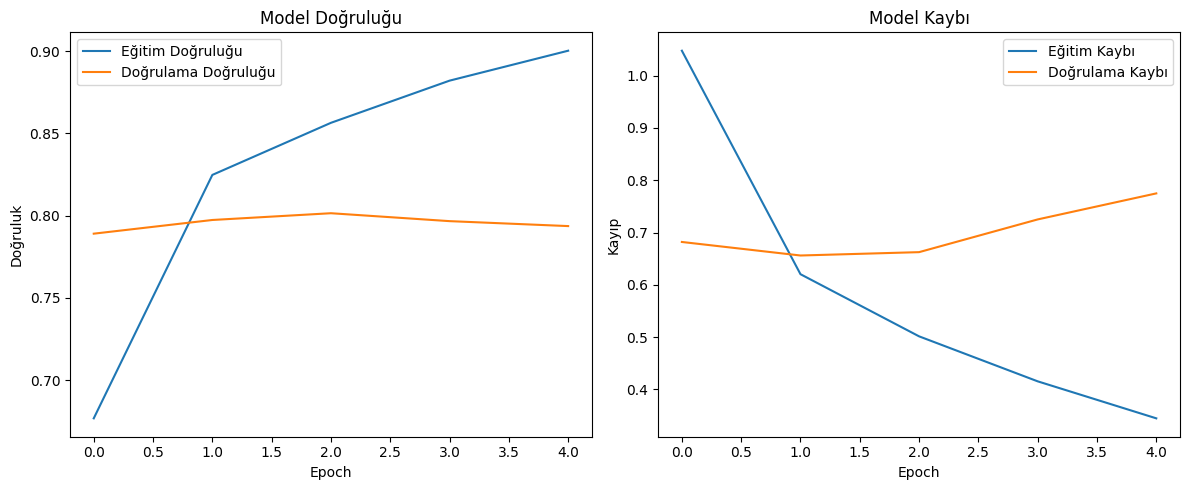

In [20]:
# Eğitim sürecini görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# Test verisi üzerinde tahmin
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Doğruluk skorunu hesaplama
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"\nTest doğruluğu: {accuracy:.4f}")

780/780 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step

Test doğruluğu: 0.8043



Sınıflandırma raporu:
                precision    recall  f1-score   support

      BUSINESS       0.62      0.56      0.59      1198
 ENTERTAINMENT       0.82      0.83      0.83      3473
  FOOD & DRINK       0.82      0.78      0.80      1268
HEALTHY LIVING       0.53      0.41      0.46      1339
     PARENTING       0.77      0.78      0.77      1758
      POLITICS       0.88      0.91      0.90      7121
  QUEER VOICES       0.86      0.71      0.78      1269
STYLE & BEAUTY       0.87      0.87      0.87      1963
        TRAVEL       0.81      0.83      0.82      1980
      WELLNESS       0.72      0.79      0.76      3589

      accuracy                           0.80     24958
     macro avg       0.77      0.75      0.76     24958
  weighted avg       0.80      0.80      0.80     24958



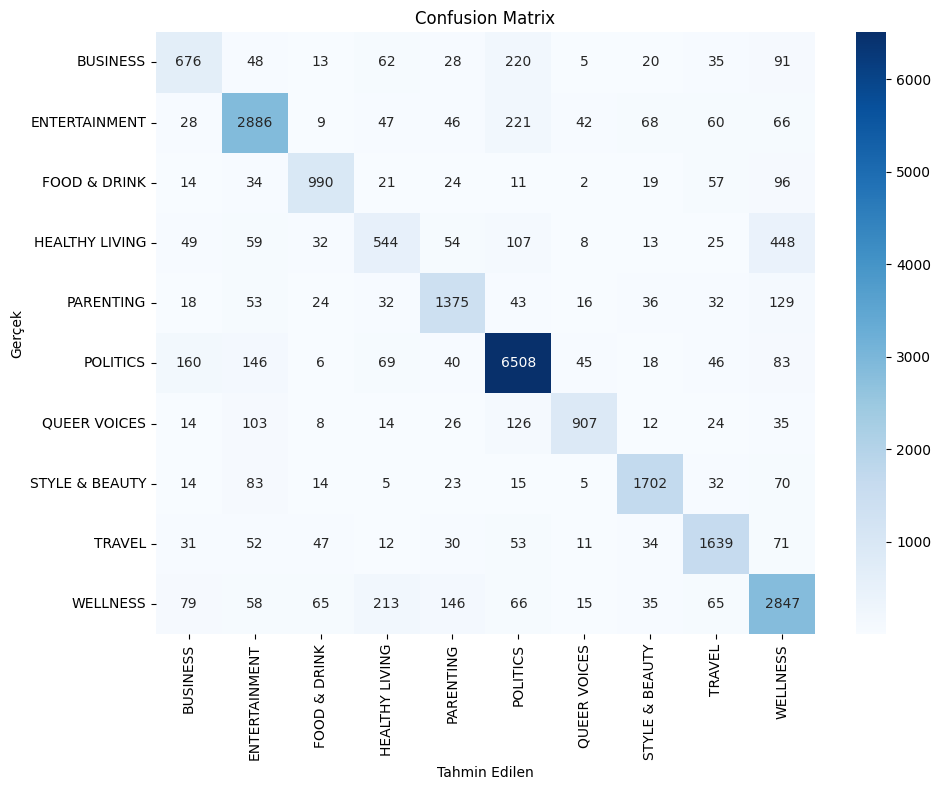

In [22]:
# Sınıflandırma raporu
print("\nSınıflandırma raporu:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
# Örnek tahminler
def predict_category(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(padded)[0]
    pred_class = label_encoder.classes_[np.argmax(pred)]
    return pred_class, pred[np.argmax(pred)]

In [24]:
print("\nÖrnek tahminler:")
for i in range(5):
    sample_text = df_filtered['text'].iloc[i]
    pred_class, confidence = predict_category(sample_text)
    print(f"Örnek: {sample_text[:100]}...")
    print(f"Gerçek kategori: {df_filtered['category'].iloc[i]}")
    print(f"Tahmin edilen kategori: {pred_class}, Güven: {confidence:.4f}")
    print()


Örnek tahminler:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Örnek: The Funniest Tweets From Parents This Week (Sept. 17-23) "Accidentally put grown-up toothpaste on my...
Gerçek kategori: PARENTING
Tahmin edilen kategori: PARENTING, Güven: 0.9852

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Örnek: Golden Globes Returning To NBC In January After Year Off-Air For the past 18 months, Hollywood has e...
Gerçek kategori: ENTERTAINMENT
Tahmin edilen kategori: ENTERTAINMENT, Güven: 0.9943

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Örnek: Biden Says U.S. Forces Would Defend Taiwan If China Invaded President issues vow as tensions with Ch...
Gerçek kategori: POLITICS
Tahmin edilen kategori: POLITICS, Güven: 0.9990

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Örnek: ‘Beautiful And Sad At The Same Time’: Ukrainian Cultural Festival Takes On A Deeper Meaning This Yea...
Gerçek kategori: POLITICS
Tahmin edilen kategori: QUEER VOICES, Güven: 0.6429

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Örnek: James Cameron Says He 'Cl

In [25]:
# Modeli kaydetme
model.save('news_category_classifier.h5')
print("Model kaydedildi: news_category_classifier.h5")

Model kaydedildi: news_category_classifier.h5


In [26]:
# Tokenizer ve LabelEncoder'ı kaydetme
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Tokenizer ve LabelEncoder kaydedildi.")

Tokenizer ve LabelEncoder kaydedildi.
